# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb

train_df = pd.read_csv('datasets/gold_recovery_train.csv', index_col='date')
test_df = pd.read_csv('datasets/gold_recovery_test.csv', index_col='date')
full_df = pd.read_csv('datasets/gold_recovery_full.csv', index_col='date')

print(f'Строки/столбцы train: {train_df.shape}')
print(f'Строки/столбцы test: {test_df.shape}')
print(f'Строки/столбцы full: {full_df.shape}')

Строки/столбцы train: (16860, 86)
Строки/столбцы test: (5856, 52)
Строки/столбцы full: (22716, 86)


Как нас и предупреждали в test-выборке меньше признаков чем в остальных, но по инструкции об этом позже. В первую очередь визуально оценим состояние данных, делать это будем на основе обучающей выборки - так как в первой задаче она и используется.

In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

Видим большое количество признаков и в них некоторое количество пропусков, прежде чем приступать к решению задачи хотелось бы обработать их.

Для начала посмотрим их количество

In [5]:
print(f'Количество пропусков в train выборке: {len(train_df) - len(train_df.dropna())}')
print(f'Количество пропусков в test выборке: {len(test_df) - len(test_df.dropna())}')
print(f'Количество пропусков в full выборке: {len(full_df) - len(full_df.dropna())}')

Количество пропусков в train выборке: 5843
Количество пропусков в test выборке: 473
Количество пропусков в full выборке: 6622


Хм, как ни странно пропуски в full выборке это не сумма train пропусков + test пропусков. Это подталкивает на вывод о том что либо данные каким-то образом могли потеряться при разделении, либо о том что пропуски сделаны искусственно, либо о том что выборки совершенно разные. 

В любом случае, для решения следующей задачи нам понадобится подвыборка без пропусков, делать её будем на train выборке так как в первой задаче именно она и нужна

Подвыборку без нулей и без пропусков создали, теперь мы можем приступить к первой задаче связанной с проверкой корректности целевого признака, для этого мы попытается сосчитать его вручную по следующей формуле:

<img src="https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg" />

Где:

* C — доля золота в концентрате после флотации/очистки;

* F — доля золота в сырье/концентрате до флотации/очистки;

* T — доля золота в отвальных хвостах после флотации/очистки.

In [6]:
def calculate_y(C, F, T):
    result = ((C * (F - T)) / (F * (C - T))) * 100
    if (result > 0) and (result < 100):
        return result
    if result > 100:
       return np.nan
    else:
        return np.nan

train_df['recovery_mypred'] = train_df.apply(lambda x: calculate_y(x['rougher.output.concentrate_au'], x['rougher.input.feed_au'], x['rougher.output.tail_au']), axis=1)
#train_df['recovery_mypred'] = train_df['recovery_mypred'].fillna(method='ffill')

display(train_df.loc[:, ['rougher.output.recovery', 'recovery_mypred']].head())

<ipython-input-6-141b1bfd134c>:2: RuntimeWarning: divide by zero encountered in double_scalars
  result = ((C * (F - T)) / (F * (C - T))) * 100
<ipython-input-6-141b1bfd134c>:2: RuntimeWarning: invalid value encountered in double_scalars
  result = ((C * (F - T)) / (F * (C - T))) * 100


,rougher.output.recovery,recovery_mypred
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794


Распределение рассчитанного вручную признака выглядит практически как оригинал, посмотрим на МАЕ

In [9]:
def mae (y, y1):
    mae = (y-y1).abs().sum() / len(y1)
    return mae

y_true = train_df['rougher.output.recovery']
y_pred = train_df['recovery_mypred']

print(mae(y_true, y_pred))

8.00350954615662e-15


И действительно низкий МАЕ, всё корректно

In [10]:
cols_list = []

for col in train_df.columns:
    if col not in test_df:
        cols_list.append(col)
        
print(cols_list)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

В тестовой выборке преимущественно отсутствуют столбцы с итоговыми признаками каждого этапа: например выводы о содержании металлов в концентрате после очисток, или содержание металлов в хвостах. Отдельно стоит отметить что в тестовой выборке также отсутствуют расчётные характеристики rougher.calculation и если они нигде не понадобятся я бы вообще их полностью удалил

Тем временем стоит вернуться к вопросу пропусков и обработать их в рамках предобработки

In [11]:
#Так как train и full имеют одинаковые колонки - мы имеем право обработать их одним циклом

for col in full_df.columns:
    full_df[col] = full_df[col].fillna(method='bfill')
    train_df[col] = train_df[col].fillna(method='bfill')

for col in test_df.columns:
    test_df[col] = test_df[col].fillna(method='bfill')
    
print(f'Количество пропусков в train выборке: {len(train_df) - len(train_df.dropna())}')
print(f'Количество пропусков в test выборке: {len(test_df) - len(test_df.dropna())}')
print(f'Количество пропусков в full выборке: {len(full_df) - len(full_df.dropna())}')

Количество пропусков в train выборке: 2899
Количество пропусков в test выборке: 0
Количество пропусков в full выборке: 0


Обрабатываем пропуски заполняя их данными из соседней-верхней ячейки, так как наши данные индексируются датой и временем и соседние значения чаще всего похожи друг на друга

### Вывод 

Пропуски обработали, корректность данных проверили, определили каких данных не хватает в test выборке

Пока у нас в нашем train'е осталась только проблема большого количества нулевых значений с которыми я не знаю что делать, предлагаю перенести решение о их будущем к концу следующего раздела.

Теперь переходим к анализу данных

# 2. Анализ данных

Для анализа данных мы будем использовать выборку train, а не подвыборку без нулей чтобы не пропустить какие-то важные инсайты которые нам могут сказать оригинальные данные

### Концентрация металлов 

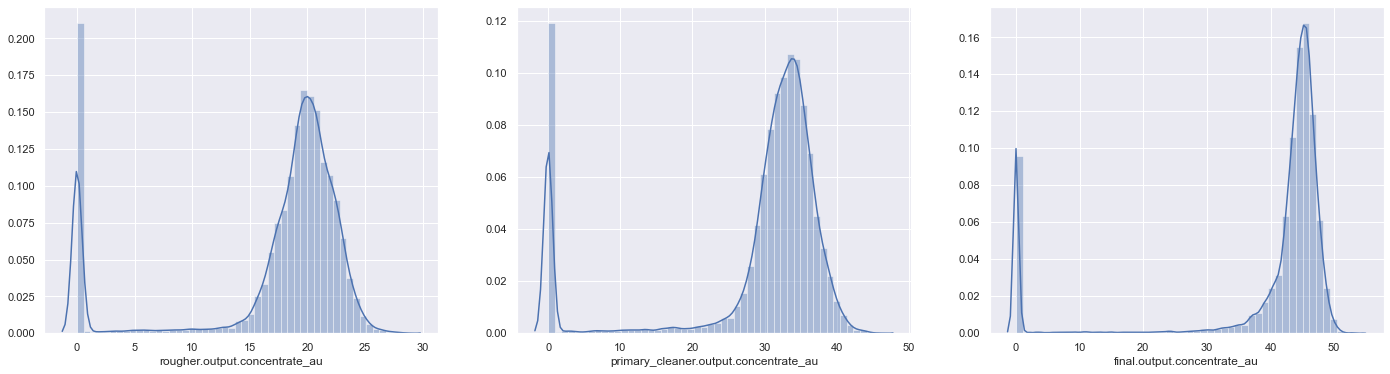

In [12]:
def create_subplots(plot1, plot2, plot3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 6))

    sns.distplot(train_df[plot1], ax=ax1)
    sns.distplot(train_df[plot2], ax=ax2)
    sns.distplot(train_df[plot3], ax=ax3)
    plt.show()

create_subplots('rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au')

Как мы видим с каждым этапом концентрация золота в продукта увеличивается, что довольно логично для процесса очистки руды

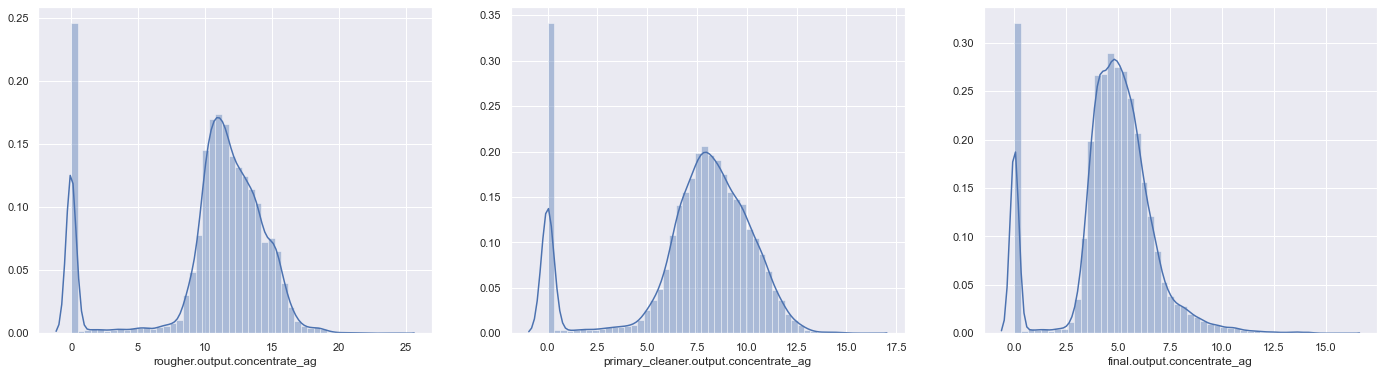

In [13]:
create_subplots('rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag')

Концентрация серебра же, наоборот, вполне логично уменьшается с каждым этапом

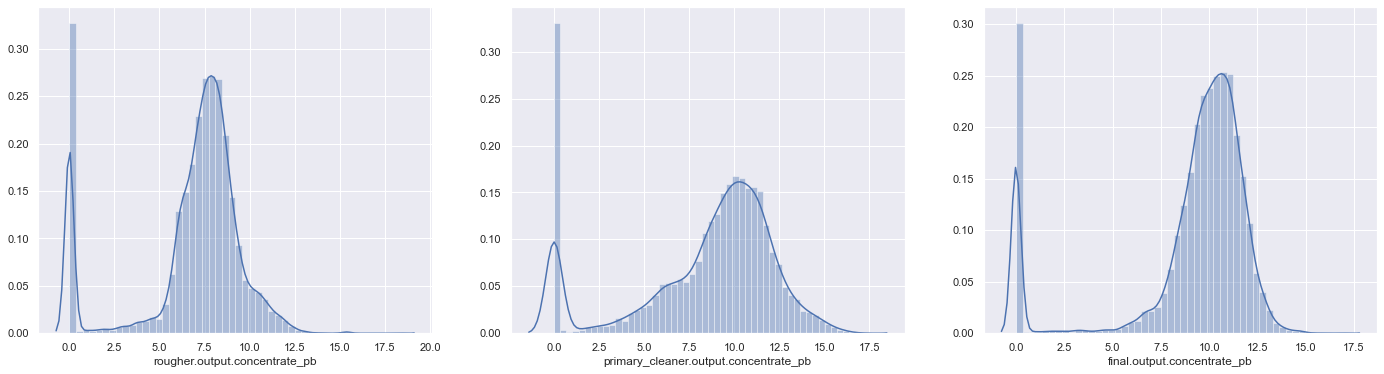

In [14]:
create_subplots('rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb')

Концентрация свинца в продукте приблизительно одинаковая на всех этапах, даже слегка увеличивается

По сути всё происходит логично, доля золота в продукте повышается, доля других элементов уменьшается, но всё ещё глаза режут все эти нулевые значения

### Распределения 

count    16860.000000
mean        58.116956
std         24.710302
min          9.659576
25%         47.381952
50%         53.840039
75%         64.613443
max        484.967466
Name: rougher.input.feed_size, dtype: float64


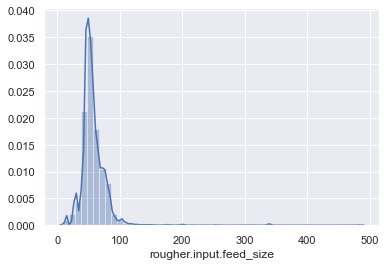

In [15]:
sns.distplot(train_df['rougher.input.feed_size'])

print(train_df['rougher.input.feed_size'].describe())

count    5856.000000
mean       55.874734
std        22.719640
min         0.046369
25%        43.889718
50%        49.959202
75%        61.615634
max       477.445473
Name: rougher.input.feed_size, dtype: float64


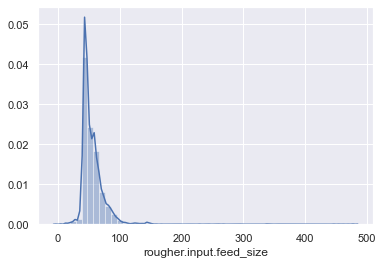

In [16]:
sns.distplot(test_df['rougher.input.feed_size'])

print(test_df['rougher.input.feed_size'].describe())

Имеются небольшие отклонения, но в целом распределения размеров гранул в train и test выборке приблизительно одинаковые

### Суммарная концентрация 

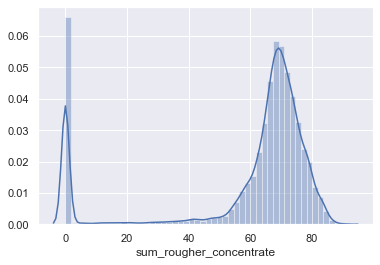

In [17]:
train_df['sum_rougher_concentrate'] = train_df['rougher.output.concentrate_ag'] + train_df['rougher.output.concentrate_au'] + train_df['rougher.output.concentrate_pb'] + train_df['rougher.output.concentrate_sol']

sns.distplot(train_df['sum_rougher_concentrate'])

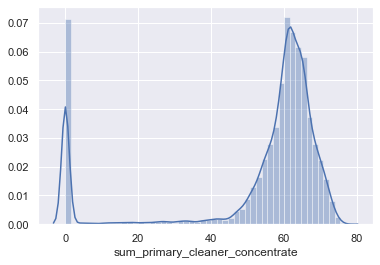

In [18]:
train_df['sum_primary_cleaner_concentrate'] = train_df['primary_cleaner.output.concentrate_ag'] + train_df['primary_cleaner.output.concentrate_au'] + train_df['primary_cleaner.output.concentrate_pb'] + train_df['primary_cleaner.output.concentrate_sol']

sns.distplot(train_df['sum_primary_cleaner_concentrate'])

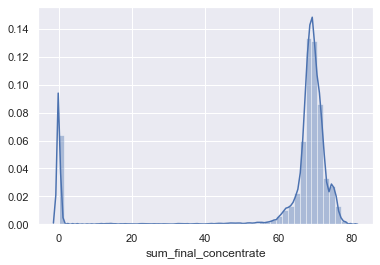

In [19]:
train_df['sum_final_concentrate'] = train_df['final.output.concentrate_ag'] + train_df['final.output.concentrate_au'] + train_df['final.output.concentrate_pb'] + train_df['final.output.concentrate_sol']

sns.distplot(train_df['sum_final_concentrate'])

На всех этапах очистки происходит одна и та же аномалия: большое число значений возле нуля, в начале мы избавлялись от них делая подвыборку, но для обучения модели от также желательно избавиться. Предлагаю заменить их пропусками и обработать также как мы раньше обрабатывали пропуски

In [20]:
for col in train_df.columns:
    train_df[col] = train_df[col].replace(0, np.nan)
    train_df[col] = train_df[col].fillna(method='bfill')
    
train_df = train_df.dropna()

print(train_df.isna().sum().sum())

0


Поступили с нулями точно также как с пропусками, теперь можно приступить к подготовке модели

# 3. Модель

### sMAPE

In [21]:
def smape(A, F):
    return 100 / len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

my_smape = make_scorer(smape)

Функцию написали и обернули в make_scorer чтобы можно было передать её в кросс-валидацию из sklearn

### Rougher sMAPE 

In [22]:
rougher_train_df = train_df.copy()
rougher_y = rougher_train_df['rougher.output.recovery']

for col in cols_list:
    rougher_train_df = rougher_train_df.drop(col, axis=1)

for col in rougher_train_df.columns:
    if 'rougher' not in col:
        rougher_train_df = rougher_train_df.drop(col, axis=1)

rougher_train_df = rougher_train_df.drop('sum_rougher_concentrate', axis=1)
print(rougher_train_df.shape)

rougher_test_df = test_df.copy()

for col in rougher_test_df.columns:
    if 'rougher' not in col:
        rougher_test_df = rougher_test_df.drop(col, axis=1)
        
print(rougher_test_df.shape)

(16846, 22)
(5856, 22)


Так как нам нужно отдельно рассчитать два целевых признака для rougher и для final - нам придётся разделить выборку. 

Для начала мы будем предсказывать rougher.recovery на rougher фичах, так как на момент флотации нам не могут быть известны параметры которые появятся в будущем

In [23]:
kfolds = KFold(n_splits=4, shuffle=True, random_state=123)

def cv_smape(model):
    acc = cross_val_score(model, rougher_train_df, rougher_y, scoring=my_smape, cv=kfolds)
    return acc

dummy_regr = DummyRegressor(strategy='mean')

print(f'Dummy Regressor sMAPE: {cv_smape(dummy_regr).mean()}')

Dummy Regressor sMAPE: 4.921312038415297


Dummy Regressor выдал значение в 4.92% sMAPE, от него и будем отталкиваться как от худшего

In [24]:
lr = LinearRegression()

print(f'Linear regression sMAPE: {cv_smape(lr).mean()}')

Linear regression sMAPE: 4.157800941482389


Линейная регрессия без нормализации отработала лучше чем Dummy, но мне кажется незначительно

In [25]:
knn = KNeighborsRegressor(n_neighbors=2)

print(f'KNeighbors Regressor sMAPE: {cv_smape(knn).mean()}')

KNeighbors Regressor sMAPE: 2.081678080485768


KNN выдал 2.08%, на данный момент лучший результат

In [23]:
tree = DecisionTreeRegressor(random_state=123, max_depth=6)

print(f'Decision Tree sMAPE: {cv_smape(tree).mean()}')

Decision Tree sMAPE: 2.9361554360142934


Дерево выдало 2.9%, хотя с большей глубиной результаты улучшаются, но боюсь что это оверфит и смысла в этом визуальном улучшении нет

In [26]:
%%time

lgbm = lgb.LGBMRegressor(n_estimators=500)
rougher_smape = cv_smape(lgbm).mean() * 100

print(f'LGBM sMAPE: {cv_smape(lgbm).mean()}')

LGBM sMAPE: 1.7745670410505574
Wall time: 8.37 s


Лучший результат выдал LGBM с практически дефолтными параметрами(только количество деревьев увеличил), любые другие изменения параметров ухудшали результат, его и будем применять дальше

In [27]:
lgbm.fit(rougher_train_df, rougher_y)
rougher_predict = lgbm.predict(rougher_test_df)

print(rougher_predict)

[90.04485155 87.91089478 88.04782383 ... 92.77865912 92.28030564
 91.4478579 ]


In [28]:
y_test = full_df['rougher.output.recovery'].loc[test_df.index].reset_index(drop=True)

rougher_smape = smape(rougher_predict, y_test.values)

print(rougher_smape)

4.552935810281786


### Final sMAPE 

In [29]:
final_train_df = train_df.copy()
final_y = final_train_df['final.output.recovery']

for col in cols_list:
    final_train_df = final_train_df.drop(col, axis=1)

final_train_df = final_train_df.drop(['sum_rougher_concentrate', 'sum_primary_cleaner_concentrate', 'sum_final_concentrate'], axis=1)

print(final_train_df.shape)
print(test_df.shape)

(16846, 52)
(5856, 52)


В отличие от rougher с предсказанием final наши руки не связаны и мы можем использовать все доступные признаки

In [30]:
kfolds = KFold(n_splits=4, shuffle=True, random_state=123)

def cv_smape_final(model):
    acc = cross_val_score(model, final_train_df, final_y, scoring=my_smape, cv=kfolds)
    return acc

dummy_regr = DummyRegressor(strategy='mean')

print(f'Dummy Regressor sMAPE: {cv_smape_final(dummy_regr).mean()}')

Dummy Regressor sMAPE: 6.7768822547410075


Повторяем все те же самые действия что и с rougher

In [31]:
print(f'Linear regression sMAPE: {cv_smape_final(lr).mean()}')

Linear regression sMAPE: 5.90183230457924


In [32]:
print(f'KNeighbors Regressor sMAPE: {cv_smape_final(knn).mean()}')

KNeighbors Regressor sMAPE: 3.538396201568779


In [33]:
tree = DecisionTreeRegressor(random_state=123, max_depth=6)

print(f'Decision Tree sMAPE: {cv_smape_final(tree).mean()}')

Decision Tree sMAPE: 4.686403289083886


In [34]:
%%time

lgbm = lgb.LGBMRegressor(n_estimators=500)
final_smape = cv_smape_final(lgbm).mean() * 100

print(f'LGBM sMAPE: {cv_smape_final(lgbm).mean()}')

LGBM sMAPE: 3.176513514020234
Wall time: 31.2 s


Как мы видим числа хоть и другие, но результаты идентичные и лидирует light gbm

In [35]:
lgbm.fit(final_train_df, final_y)
final_predict = lgbm.predict(test_df)

print(final_predict)

[65.95251543 64.4953749  64.08714799 ... 67.45715553 73.61810695
 72.13179854]


In [36]:
y_test_final = full_df['final.output.recovery'].loc[test_df.index].reset_index(drop=True)

final_smape = smape(final_predict, y_test_final.values)

print(final_smape)

10.598174792584302


### Итоговое sMAPE 

In [37]:
result_smape = (0.25 * rougher_smape) + (0.75 * final_smape)

print(result_smape)

9.086865047008674


Итоговая метрика 9.08% чего вполне достаточно для сдачи проекта.